In [77]:
# Cell 0 — imports & config
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from types import SimpleNamespace

from HNA.modules.utils import get_condition_segments
from HNA.modules.coupling import (
    windowed_xcorr, band_coherence, band_coherence_windowed,
    plv_phase_sync, windowed_plv,
    wpli_phase_sync, windowed_wpli,
    plot_coupling_over_time, plot_coherence_results,
)

# paths
ROOT = Path(r"C:\Users\andre\Documents\github\HumanNatureAttunement")  # adjust if needed
PROCESSED = ROOT / "data" / "processed"

# sampling & analysis params
FS        = 256.0
ENVELOPES = ("env_swell_0p3", "env_swell_0p3hz", "env_broad")  # try in this order
COH_FMIN, COH_FMAX = 0.05, 0.5
PLV_BW    = 0.12

# default window targets (we'll adapt per segment to avoid crashes)
XC_WIN  = 120.0   # seconds
XC_STEP = 10.0
XC_LAG  = 10.0


In [78]:
# Cell 1 — helpers

def pair_segments(indices_dict: dict) -> dict:
    """Turn start/stop index dict into {condition: (start, stop)}."""
    segs = {}
    for k, v in indices_dict.items():
        if isinstance(k, str) and k.endswith("_start") and v is not None:
            base = k[:-6]
            stop = indices_dict.get(base + "_stop", None)
            if stop is not None:
                segs[base] = (int(v), int(stop))
    return segs

def choose_envelope_column(df: pd.DataFrame, candidates=ENVELOPES) -> str:
    for c in candidates:
        if c in df.columns:
            return c
    raise RuntimeError(f"No envelope column found. Tried: {candidates}")

def effective_window_params(seg_len_s: float, fs: float,
                            target_win: float, target_step: float, target_lag: float):
    """Pick safe per-segment window/step/lag; return None if too short."""
    win = min(target_win, seg_len_s)
    if win < max(2.0/fs, 1.0):  # tiny segments: skip windowed metrics
        return None
    step = min(target_step, max(win/2.0, 2.0/fs))
    max_lag = min(target_lag, max(win/2.0 - 1.0/fs, 1.0/fs))
    return win, step, max_lag


In [86]:
# Cell 2 — load one subject table (already contains respiration_clean from your other notebook)
subj = "06"  # change here to explore others
tables = PROCESSED / f"sub-{int(subj):02d}" / "tables"
merged = tables / "merged_annotated_with_audio.csv"

df = pd.read_csv(merged, low_memory=False)
if "time_s" not in df.columns:
    df["time_s"] = np.arange(len(df), dtype=float) / FS

assert "respiration_clean" in df.columns, \
    "respiration_clean not found. Run your respiration notebook first."

env_col = choose_envelope_column(df)
print("Using envelope column:", env_col)

# get segments per condition
indices = get_condition_segments(df, df["condition_names"].unique())
segments = pair_segments(indices)
segments


Using envelope column: env_swell_0p3


{'RS1': (56471, 108203),
 'AUD': (199403, 242705),
 'VIZ': (317437, 386950),
 'MULTI': (387031, 462387),
 'RS2': (545726, 597725)}

In [87]:
# Cell 3 — one-condition demo
cond = next(k for k in segments.keys() if k.upper() != "AUDIO_SYNC")  # first non-sync condition
cond = "RS1"
start, stop = segments[cond]
r = df.iloc[start:stop]

resp = r["respiration_clean"].to_numpy(float)
env  = r[env_col].to_numpy(float)
seg_len_s = len(resp) / FS

# global metrics
plv_g  = plv_phase_sync(resp, env, fs=FS, bw_hz=PLV_BW)
wpli_g = wpli_phase_sync(resp, env, fs=FS, bw_hz=PLV_BW)
coh_g  = band_coherence(resp, env, fs=FS, fmin=COH_FMIN, fmax=COH_FMAX, windowed=False)


# windowed metrics (adaptive)
params = effective_window_params(seg_len_s, FS, XC_WIN, XC_STEP, XC_LAG)
if params is None:
    print(f"[{subj}/{cond}] segment too short for windowed metrics ({seg_len_s:.1f}s).")
    xc = None
    plv_w = {"times_s": np.array([]), "plv": np.array([]), "preferred_lag_s": np.array([])}
    wpli_w = {"times_s": np.array([]), "wpli": np.array([])}
    coh_w = {"f": coh_g.f, "Cxy": coh_g.Cxy, "peak_f": coh_g.peak_f, "peak_coh": coh_g.peak_coh,
             "band_avg_coh": coh_g.band_avg_coh, "times_s": np.array([]), "band_avg_coh_win": np.array([])}
else:
    win_eff, step_eff, lag_eff = params
    print(f"Windowed params → win={win_eff:.1f}s, step={step_eff:.1f}s, max_lag={lag_eff:.1f}s")
    xc     = windowed_xcorr(resp, env, fs=FS, win_sec=win_eff, step_sec=step_eff, max_lag_sec=lag_eff)
    plv_w  = windowed_plv(resp, env, fs=FS, win_sec=win_eff, step_sec=step_eff)
    wpli_w = windowed_wpli(resp, env, fs=FS, win_sec=win_eff, step_sec=step_eff)
    coh_w  = band_coherence_windowed(resp, env, fs=FS, fmin=COH_FMIN, fmax=COH_FMAX,
                                     win_sec=win_eff, step_sec=step_eff)

# peek summary
summary_one = {
    "subject": subj, "condition": cond, "env_col": env_col,
    "plv": float(plv_g.plv), "plv_pref_lag_s": float(plv_g.preferred_lag_s),
    "wpli": float(wpli_g.wpli), "coh_peak": float(coh_g.peak_coh),
    "coh_band_avg": float(coh_g.band_avg_coh),
    "xcorr_mean_peak_r": (float(np.nanmean(xc.peak_r)) if xc is not None else np.nan),
    "xcorr_mean_peak_lag_s": (float(np.nanmean(xc.peak_lag_s)) if xc is not None else np.nan),
}
summary_one


Windowed params → win=120.0s, step=10.0s, max_lag=10.0s


{'subject': '06',
 'condition': 'RS1',
 'env_col': 'env_swell_0p3',
 'plv': 0.19747327910417334,
 'plv_pref_lag_s': 3.2129246542315215,
 'wpli': 0.16268903828613027,
 'coh_peak': 1.0000000000000007,
 'coh_band_avg': 1.0,
 'xcorr_mean_peak_r': 0.1277834836675521,
 'xcorr_mean_peak_lag_s': 2.275607638888889}

In [88]:
# # compute once per condition (or per subject) from respiration
# from HNA.modules.coupling import _dominant_freq
# f0_resp = _dominant_freq(resp, fs=FS, fmin=0.05, fmax=0.5)

# plv  = plv_phase_sync(resp, env, fs=FS, f0=f0_resp, bw_hz=PLV_BW)
# wpli = wpli_phase_sync(resp, env, fs=FS, f0=f0_resp, bw_hz=PLV_BW)

# # windowed with fixed f0
# win_plv  = windowed_plv(resp, env, fs=FS, win_sec=WIN, step_sec=STEP, f0=f0_resp)
# win_wpli = windowed_wpli(resp, env, fs=FS, win_sec=WIN, step_sec=STEP, f0=f0_resp)


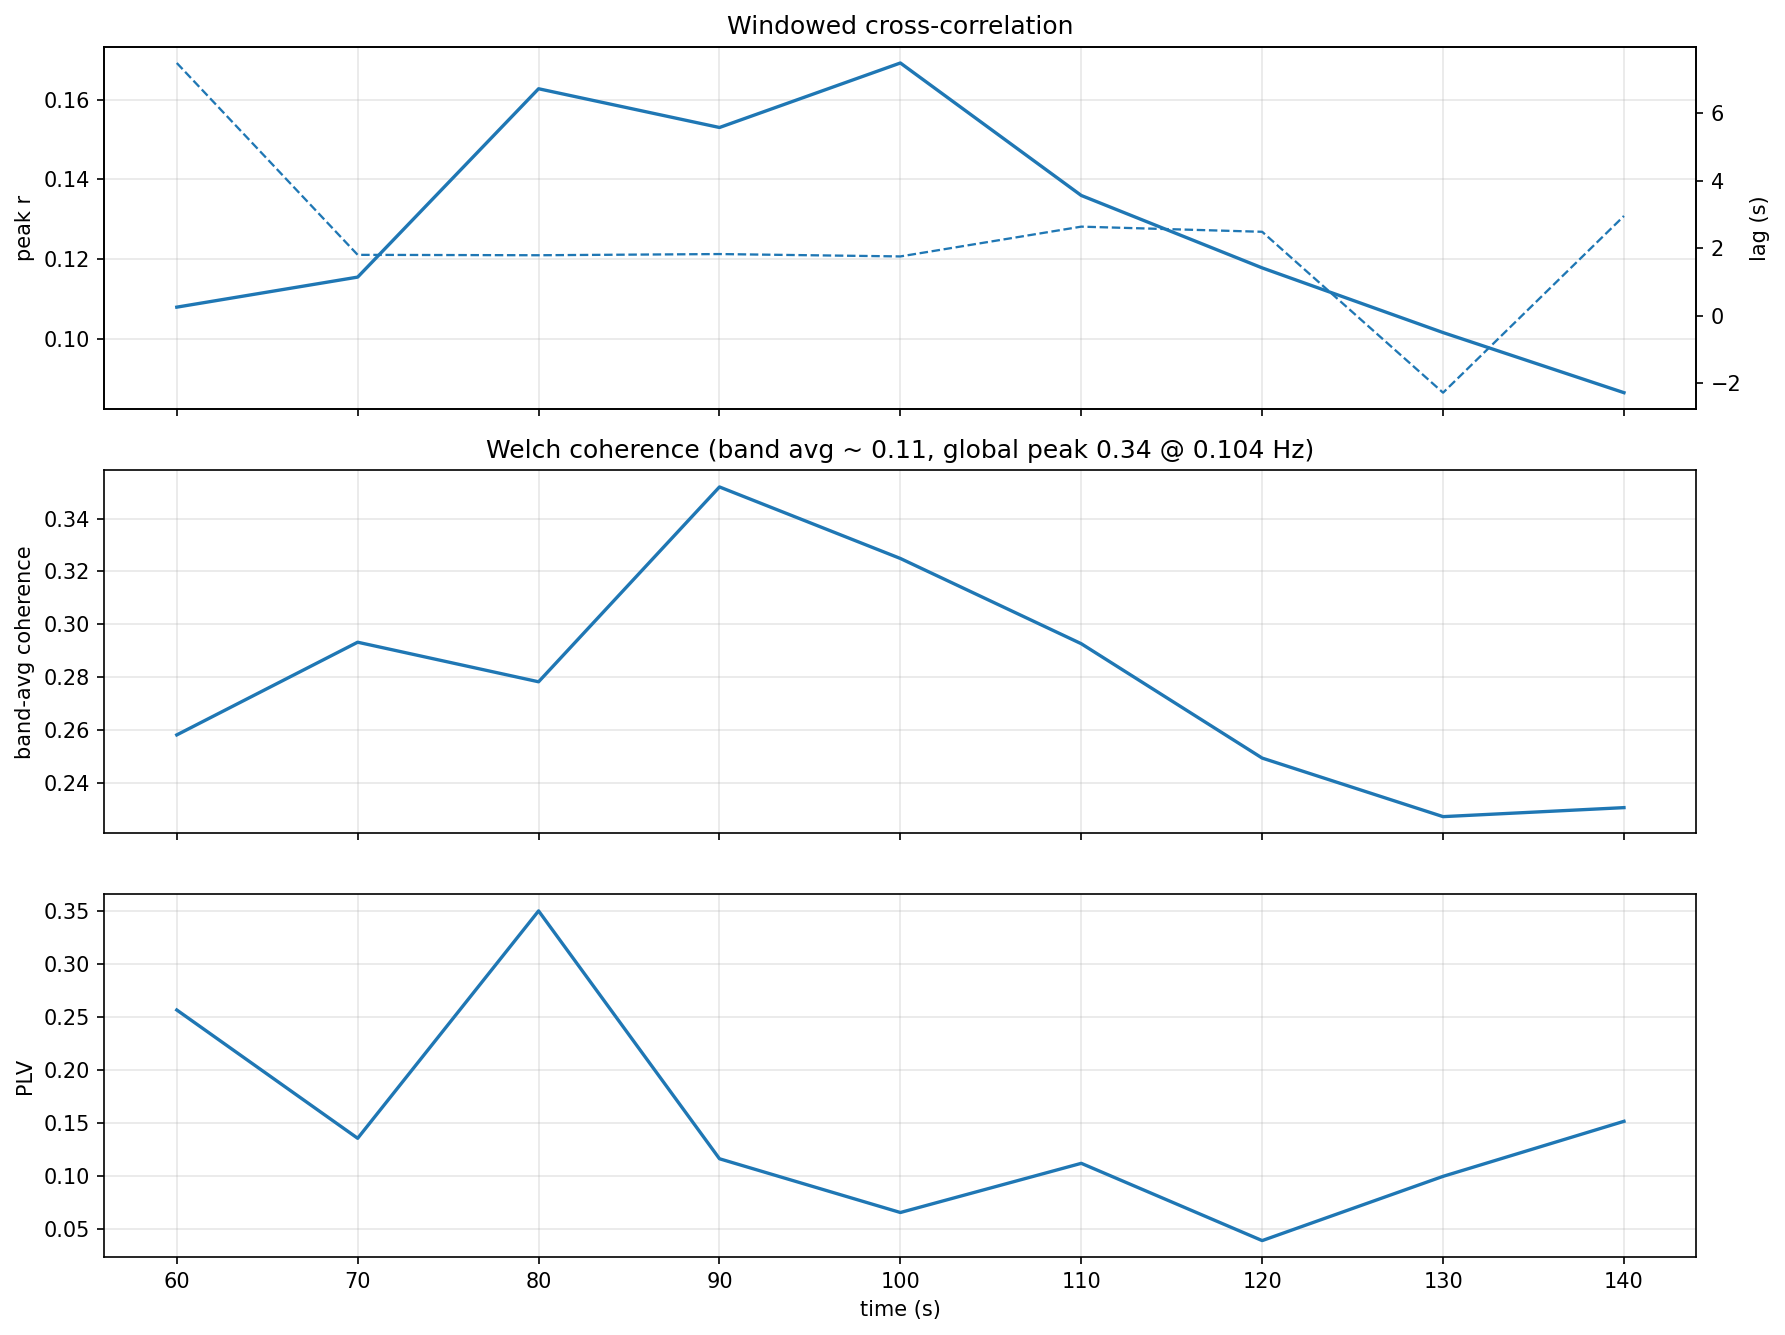

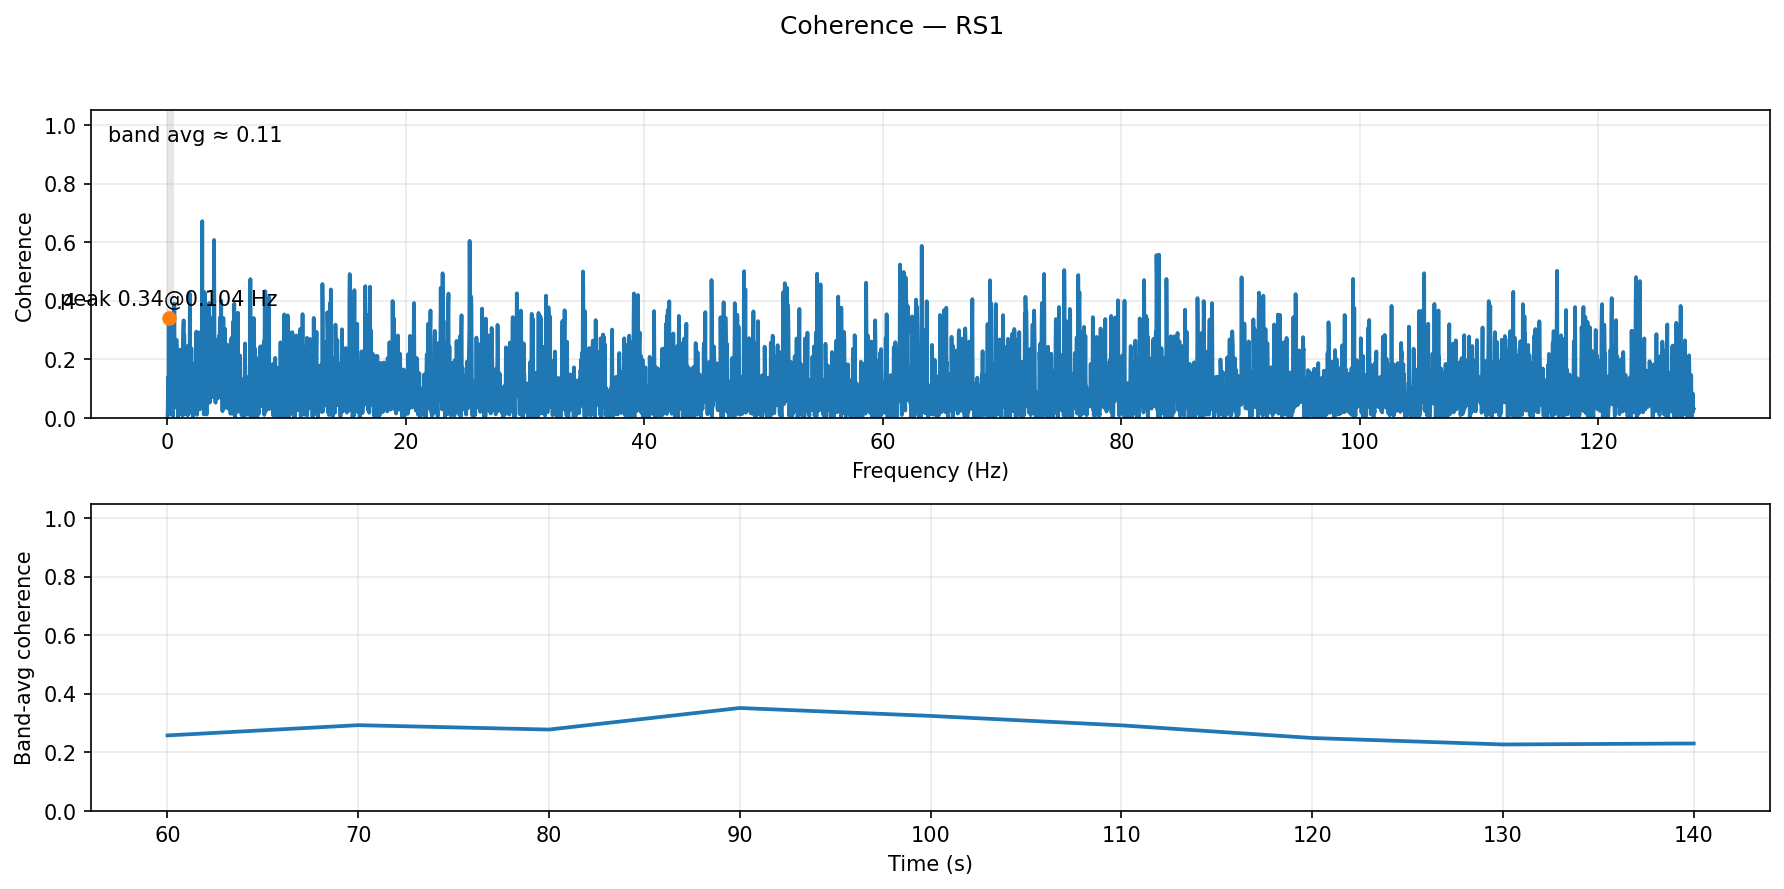

In [89]:
# Cell 4 — plots
plots_dir = (PROCESSED / f"sub-{int(subj):02d}" / "plots")
plots_dir.mkdir(parents=True, exist_ok=True)

# plot_coupling_over_time expects attribute-style coherence; wrap dict if needed
coh_for_plot = SimpleNamespace(**coh_w) if isinstance(coh_w, dict) else coh_w

fig1 = plot_coupling_over_time(xc, coh_for_plot, plv_w)
plt.show()

#fig1.savefig(plots_dir / f"{cond}_coupling_timeseries.png", dpi=160); plt.close(fig1)

fig2 = plot_coherence_results(coh_w, band=(COH_FMIN, COH_FMAX), title=f"Coherence — {cond}")
#show plot
plt.show()
#fig2.savefig(plots_dir / f"{cond}_coherence.png", dpi=160); plt.close(fig2)

#print("Saved plots in:", plots_dir)


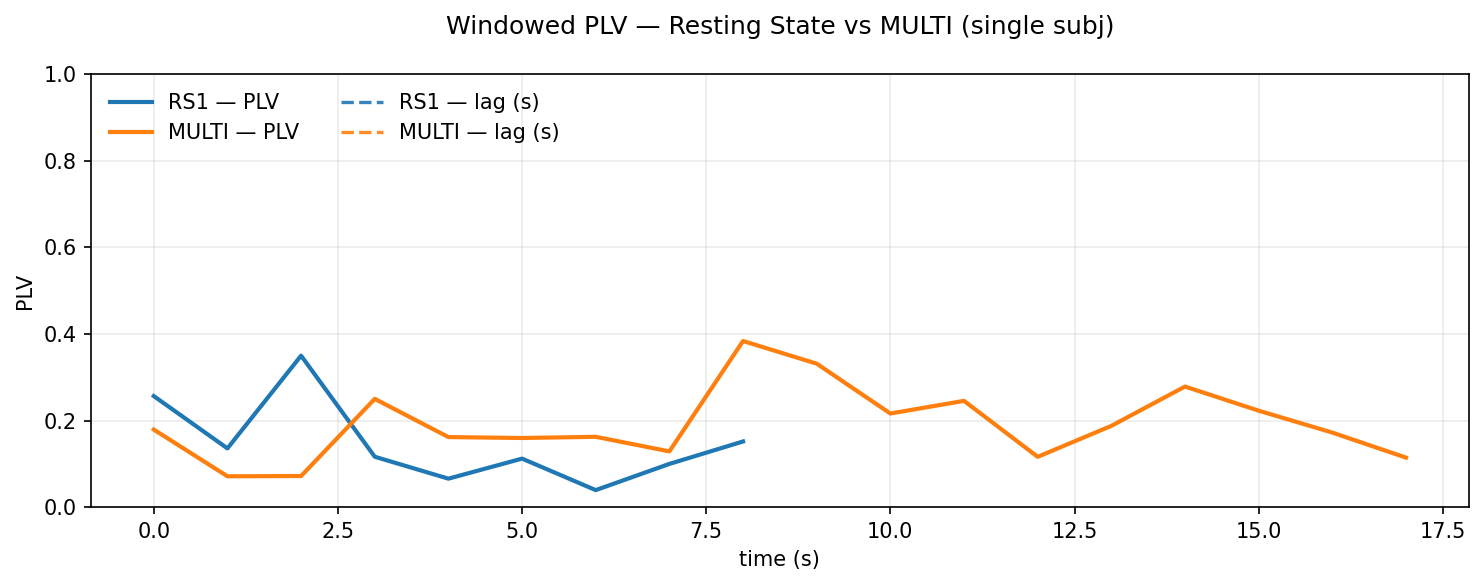

In [90]:
# === Overlay RS1 vs MULTI: windowed PLV (+ preferred lag) ===
conds = ["RS1", "MULTI"]
colors = {"RS1": "#1f77b4", "MULTI": "#ff7f0e"}  # two distinct, color-blind–friendly defaults

results = {}
win_info = {}  # keep per-condition window params for reference

for cond in conds:
    if cond not in segments:
        print(f"[warn] {cond} not found in segments; skipping.")
        continue

    start, stop = segments[cond]
    r = df.iloc[start:stop]

    resp = r["respiration_clean"].to_numpy(float)
    env  = r[env_col].to_numpy(float)
    seg_len_s = len(resp) / FS

    params = effective_window_params(seg_len_s, FS, XC_WIN, XC_STEP, XC_LAG)
    if params is None:
        print(f"[{cond}] segment too short for windowed metrics ({seg_len_s:.1f}s). Skipping.")
        continue

    win_eff, step_eff, lag_eff = params
    win_info[cond] = (win_eff, step_eff, lag_eff)

    plv_w = windowed_plv(resp, env, fs=FS, win_sec=win_eff, step_sec=step_eff)  # returns dict
    # convert to absolute time (s) along the full recording so RS1/MULTI align correctly on x-axis
    t_abs = plv_w["times_s"] + (start / FS)



    results[cond] = {
        "t":   t_abs,
        "plv": plv_w["plv"],
        "lag": plv_w["preferred_lag_s"],
    }

# ---- Plot
import matplotlib.pyplot as plt
plt.rcParams.update({"figure.dpi": 150})

fig, ax1 = plt.subplots(figsize=(10, 4))

# PLV (solid)
for cond in results:
    d = results[cond]
    ax1.plot(d["plv"], lw=2, color=colors[cond], label=f"{cond} — PLV")

ax1.set_xlabel("time (s)")
ax1.set_ylabel("PLV")
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.25)

# # Preferred lag (dashed) on twin y-axis
# ax2 = ax1.twinx()
# for cond in results:
#     d = results[cond]
#     ax2.plot(d["t"], d["lag"], "--", lw=1.6, color=colors[cond], alpha=0.9, label=f"{cond} — lag (s)")
# ax2.set_ylabel("lag (s)")

# Title (shows per-condition window params if they differ)
title_bits = []
for cond, (w, s, L) in win_info.items():
    title_bits.append(f"{cond}: win {w:.1f}s, step {s:.1f}s, max lag {L:.1f}s")
ax1.set_title("Windowed PLV — Resting State vs MULTI (single subj)\n")

# One combined legend
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc="upper left", ncol = 2, frameon=False)

plt.tight_layout()
plt.show()

# Optional save for PowerPoint
# out = plots_dir / f"RS1_vs_MULTI_windowed_PLV.png"
# fig.savefig(out, dpi=300, bbox_inches="tight")
# print("Saved:", out)


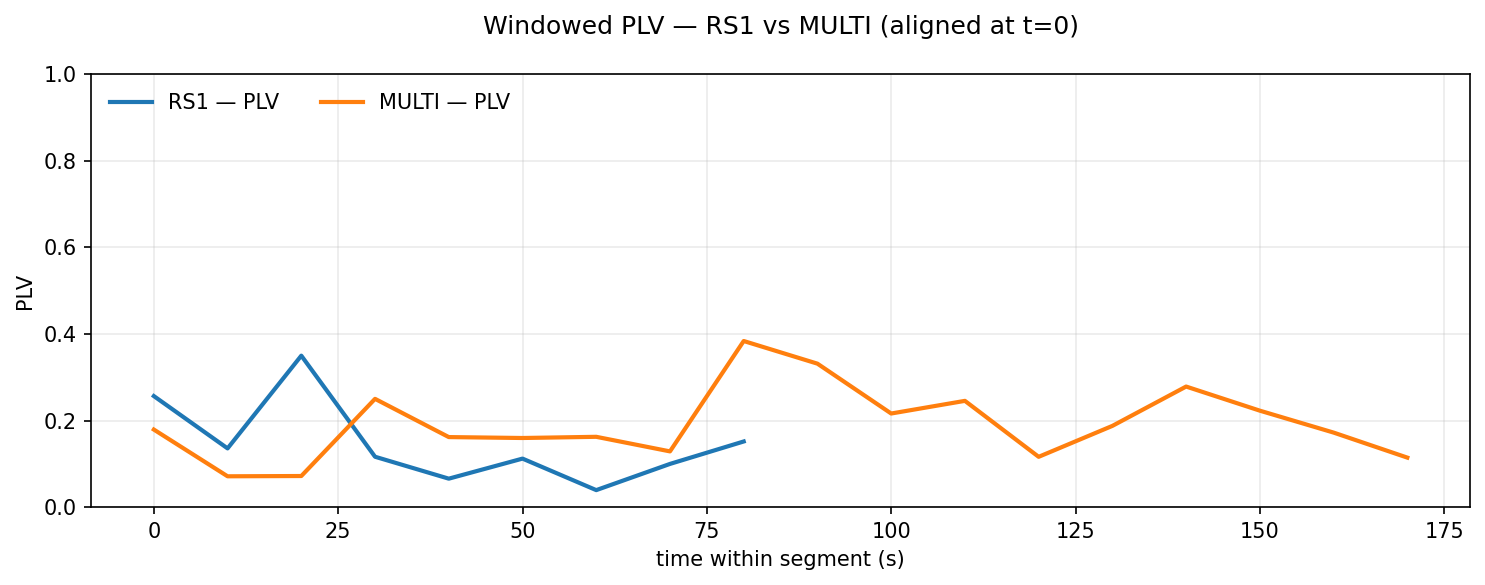

In [91]:
# === Overlay RS1 vs MULTI: windowed PLV (+ preferred lag) ===
conds = ["RS1", "MULTI"]
colors = {"RS1": "#1f77b4", "MULTI": "#ff7f0e"}

results, win_info = {}, {}

for cond in conds:
    if cond not in segments:
        print(f"[warn] {cond} not found in segments; skipping.")
        continue

    start, stop = segments[cond]
    r = df.iloc[start:stop]

    resp = r["respiration_clean"].to_numpy(float)
    env  = r[env_col].to_numpy(float)
    seg_len_s = len(resp) / FS

    params = effective_window_params(seg_len_s, FS, XC_WIN, XC_STEP, XC_LAG)
    if params is None:
        print(f"[{cond}] segment too short for windowed metrics ({seg_len_s:.1f}s). Skipping.")
        continue

    win_eff, step_eff, lag_eff = params
    win_info[cond] = (win_eff, step_eff, lag_eff)

    plv_w = windowed_plv(resp, env, fs=FS, win_sec=win_eff, step_sec=step_eff)

    # --- make both start at 0 s (relative-to-segment timeline) ---
    t_rel = plv_w["times_s"] - plv_w["times_s"][0]   # first point -> 0.0 s

    results[cond] = {
        "t":   t_rel,                 # <— use relative seconds on x-axis
        "plv": plv_w["plv"],
        "lag": plv_w["preferred_lag_s"],
    }

# ---- Plot
import matplotlib.pyplot as plt
plt.rcParams.update({"figure.dpi": 150})

fig, ax1 = plt.subplots(figsize=(10, 4))

# PLV (solid) vs relative time
for cond, d in results.items():
    ax1.plot(d["t"], d["plv"], lw=2, color=colors[cond], label=f"{cond} — PLV")

ax1.set_xlabel("time within segment (s)")     # now starts at 0 for both
ax1.set_ylabel("PLV")
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.25)

# Title
title_bits = [f"{c}: win {w:.1f}s, step {s:.1f}s, max lag {L:.1f}s"
              for c, (w, s, L) in win_info.items()]
ax1.set_title("Windowed PLV — RS1 vs MULTI (aligned at t=0)\n" ) #+ " | ".join(title_bits))

# Legend (single axis only; you commented ax2 out)
ax1.legend(loc="upper left", ncol=2, frameon=False)

plt.tight_layout()
plt.show()


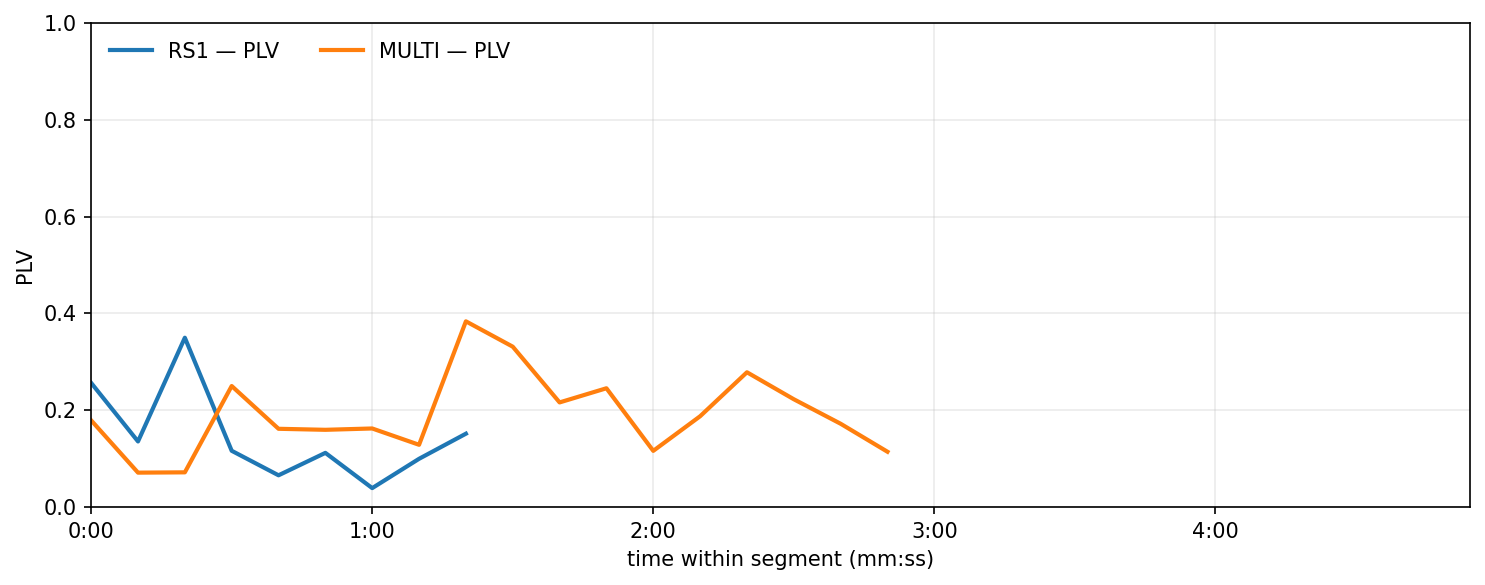

In [92]:
from matplotlib.ticker import MultipleLocator, FuncFormatter

conds = ["RS1", "MULTI"]
colors = {"RS1": "#1f77b4", "MULTI": "#ff7f0e"}
results, win_info, seg_durations = {}, {}, {}

for cond in conds:
    start, stop = segments[cond]
    r = df.iloc[start:stop]
    resp = r["respiration_clean"].to_numpy(float)
    env  = r[env_col].to_numpy(float)
    seg_len_s = len(resp) / FS
    seg_durations[cond] = seg_len_s

    win_eff, step_eff, lag_eff = effective_window_params(seg_len_s, FS, XC_WIN, XC_STEP, XC_LAG)
    win_info[cond] = (win_eff, step_eff, lag_eff)

    plv_w = windowed_plv(resp, env, fs=FS, win_sec=win_eff, step_sec=step_eff)

    # Make both start at 0 s (relative-to-segment timeline)
    t_rel = plv_w["times_s"] - plv_w["times_s"][0]

    results[cond] = {"t": t_rel, "plv": plv_w["plv"]}

# ---- Plot
fig, ax1 = plt.subplots(figsize=(10, 4))
for cond, d in results.items():
    ax1.plot(d["t"], d["plv"], lw=2, color=colors[cond], label=f"{cond} — PLV")

ax1.set_ylabel("PLV"); ax1.set_ylim(0, 1); ax1.grid(True, alpha=0.25)
ax1.set_xlabel("time within segment (mm:ss)")

# Show full 0–5 min (or to each segment's true length if different)
max_dur = max(seg_durations.values())   # e.g., ~300 s
ax1.set_xlim(0, max_dur)

# mm:ss ticks every 60 s
ax1.xaxis.set_major_locator(MultipleLocator(60))
ax1.xaxis.set_major_formatter(FuncFormatter(lambda s, _: f"{int(s//60)}:{int(s%60):02d}"))

ax1.legend(loc="upper left", ncol=2, frameon=False)
plt.tight_layout(); plt.show()


Found 5 subject files.
Subjects used per condition: {'RS1': 4, 'MULTI': 4}
Median segment lengths (s): {'RS1': 247.48828125, 'MULTI': 294.359375}


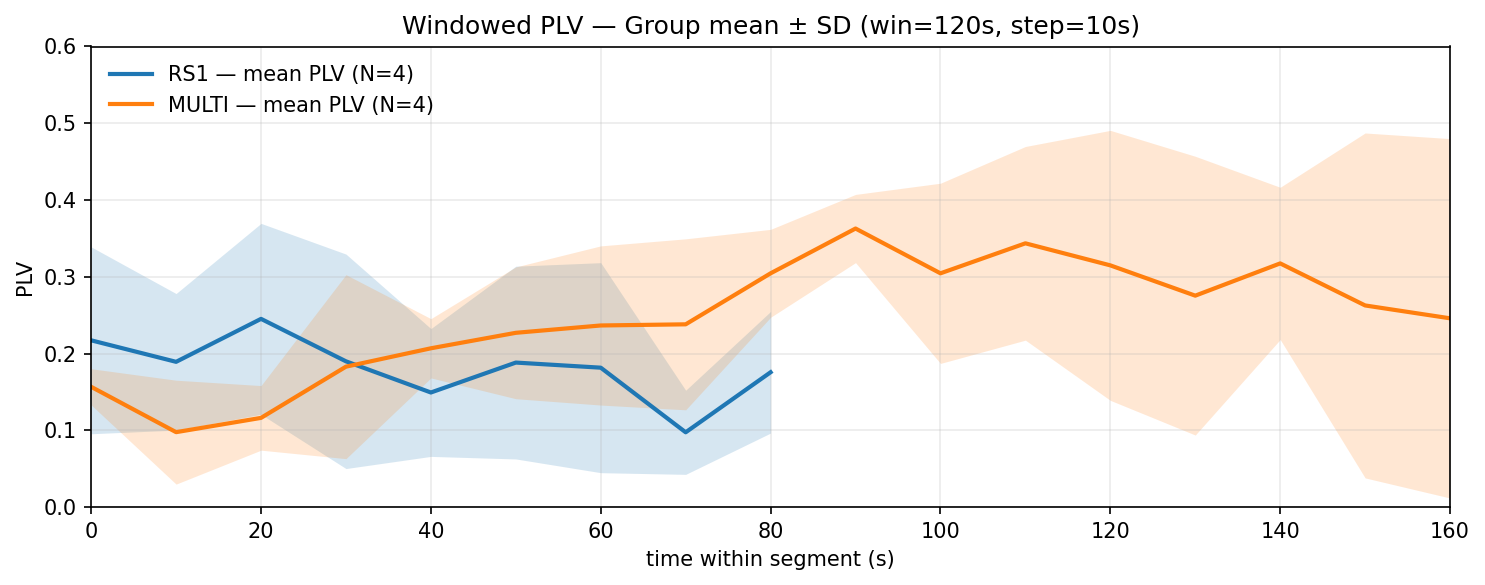

In [99]:
# ==== Group plot: RS1 vs MULTI — mean PLV + SD band across all subjects ====
from collections import defaultdict
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- config (fixed window/step for comparability) ---
conds = ["RS1", "MULTI"]
colors = {"RS1": "#1f77b4", "MULTI": "#ff7f0e"}

WIN_SEC  = 120.0        # <-- choose a stable window (60 s recommended)
STEP_SEC = 10.0        # <-- step for smooth curves
GRID_STEP = STEP_SEC   # common grid step (seconds)

# --- discover subjects (expects your folder structure) ---
csv_paths = sorted(PROCESSED.glob("sub-*/tables/merged_annotated_with_audio.csv"))
print(f"Found {len(csv_paths)} subject files.")

def load_subject_df(p: Path) -> tuple[str, pd.DataFrame]:
    sid = p.parts[-3].split("-")[-1]   # sub-XX -> "XX"
    df = pd.read_csv(p, low_memory=False)
    if "time_s" not in df.columns:
        df["time_s"] = np.arange(len(df), dtype=float) / FS
    return sid, df

# --- per-subject PLV time series collector ---
curves = {c: [] for c in conds}      # {cond: [(t_rel, plv), ...]}
seg_durations = {c: [] for c in conds}
n_attempted = defaultdict(int)
n_used = defaultdict(int)

for p in csv_paths:
    sid, df_subj = load_subject_df(p)

    # sanity: respiration + envelope
    if "respiration_clean" not in df_subj.columns:
        print(f"[skip {sid}] respiration_clean missing")
        continue
    try:
        env_col_subj = choose_envelope_column(df_subj, ENVELOPES)
    except RuntimeError as e:
        print(f"[skip {sid}] {e}")
        continue

    # segments for this subject
    try:
        indices = get_condition_segments(df_subj, df_subj["condition_names"].unique())
    except Exception as e:
        print(f"[skip {sid}] get_condition_segments failed: {e}")
        continue
    segs = pair_segments(indices)

    # process each condition
    for cond in conds:
        n_attempted[cond] += 1
        if cond not in segs:
            # missing condition in this subject
            continue

        s0, s1 = segs[cond]
        df_seg = df_subj.iloc[int(s0):int(s1)]
        seg_len_s = len(df_seg) / FS
        seg_durations[cond].append(seg_len_s)

        # require segment long enough for chosen window
        if seg_len_s < (WIN_SEC + STEP_SEC):
            # too short to get at least a couple points
            continue

        # compute windowed PLV with fixed WIN/STEP for comparability
        resp = df_seg["respiration_clean"].to_numpy(float)
        env  = df_seg[env_col_subj].to_numpy(float)
        plv_w = windowed_plv(resp, env, fs=FS, win_sec=WIN_SEC, step_sec=STEP_SEC)

        # align to t=0 (relative)
        t_rel = plv_w["times_s"] - plv_w["times_s"][0]
        curves[cond].append((t_rel, plv_w["plv"]))
        n_used[cond] += 1

print("Subjects used per condition:", {c: n_used[c] for c in conds})
print("Median segment lengths (s):", {c: (np.median(seg_durations[c]) if seg_durations[c] else np.nan) for c in conds})

# --- build common time grid per condition (truncate to shared coverage) ---
t_end = {}
for cond in conds:
    if not curves[cond]:
        t_end[cond] = 0.0
    else:
        # shortest coverage among subjects for this condition
        t_end[cond] = min(ts[-1] for ts, _ in curves[cond])

t_grid = {cond: np.arange(0, t_end[cond] + 1e-9, GRID_STEP) for cond in conds}

# --- interpolate each subject onto the grid and compute mean/SD (or SEM) ---
grid_plvs = {}
for cond in conds:
    if not curves[cond] or t_end[cond] <= 0:
        continue
    Tg = t_grid[cond]
    mats = []
    for t_rel, plv in curves[cond]:
        # interpolate within overlap; NaN outside
        y = np.interp(Tg, t_rel, plv, left=np.nan, right=np.nan)
        mats.append(y)
    grid = np.vstack(mats)                           # shape (n_subj, T)
    n   = np.sum(~np.isnan(grid), axis=0)
    mean = np.nanmean(grid, axis=0)
    sd   = np.nanstd(grid, axis=0)
    sem  = sd / np.sqrt(np.maximum(n, 1))
    grid_plvs[cond] = {"t": Tg, "mean": mean, "sd": sd, "sem": sem, "n": n}

# --- plot group mean + shaded band ---
plt.figure(figsize=(10, 4))
for cond in conds:
    if cond not in grid_plvs:
        continue
    t = grid_plvs[cond]["t"]
    m = grid_plvs[cond]["mean"]
    s = grid_plvs[cond]["sd"]      # ← change to ["sem"] if you prefer SEM
    plt.plot(t, m, lw=2, color=colors[cond], label=f"{cond} — mean PLV (N={int(np.nanmax(grid_plvs[cond]['n']))})")
    plt.fill_between(t, m - s, m + s, color=colors[cond], alpha=0.18, linewidth=0)

plt.ylim(0, 0.6)
# show full nominal 5 min for context if desired; comment the next line to auto-fit
# plt.xlim(0, 300)
# or: fit to available common coverage across both conditions
if grid_plvs:
    xmax = max(grid_plvs[c]["t"][-1] for c in grid_plvs)
    plt.xlim(0, xmax)

plt.xlabel("time within segment (s)")
plt.ylabel("PLV")
plt.grid(True, alpha=0.25)
plt.legend(loc="upper left", frameon=False)
plt.title(f"Windowed PLV — Group mean ± SD (win={WIN_SEC:.0f}s, step={STEP_SEC:.0f}s)")
plt.tight_layout()
plt.show()


In [69]:
for cond in ["RS1", "MULTI"]:
    start, stop = segments[cond]
    seg_len_s = (stop - start) / FS
    win_eff, step_eff, lag_eff = effective_window_params(seg_len_s, FS, XC_WIN, XC_STEP, XC_LAG)
    plv_w = windowed_plv(df.loc[start:stop-1, "respiration_clean"],
                         df.loc[start:stop-1, env_col],
                         fs=FS, win_sec=win_eff, step_sec=step_eff)
    t0, t1 = float(plv_w["times_s"][0]), float(plv_w["times_s"][-1])
    print(f"{cond}: seg_len={seg_len_s:.1f}s | win={win_eff:.1f}s | t-range={t0:.1f}–{t1:.1f}s "
          f"(span={t1 - t0:.1f}s) | npts={len(plv_w['times_s'])}")

RS1: seg_len=330.5s | win=120.0s | t-range=60.0–270.0s (span=210.0s) | npts=22
MULTI: seg_len=289.4s | win=120.0s | t-range=60.0–220.0s (span=160.0s) | npts=17


In [23]:
# Cell 5 — all conditions for this subject; save JSON + per-subject summary CSV
#          PLUS save windowed values for violin plots (long-form)

rows = []         # per-condition summary rows (one per condition)
win_rows = []     # long-form windowed rows for violin plots (many per condition)

for cond, (start, stop) in segments.items():
    if cond.upper() == "AUDIO_SYNC":
        continue

    r = df.iloc[start:stop]
    resp = r["respiration_clean"].to_numpy(float)
    env  = r[env_col].to_numpy(float)
    seg_len_s = len(resp) / FS

    # ---- global metrics (no windowing) ----
    plv_g  = plv_phase_sync(resp, env, fs=FS, bw_hz=PLV_BW)
    wpli_g = wpli_phase_sync(resp, env, fs=FS, bw_hz=PLV_BW)
    coh_g  = band_coherence(resp, env, fs=FS, fmin=COH_FMIN, fmax=COH_FMAX, windowed=False)

    # ---- windowed metrics (adaptive) ----
    params = effective_window_params(seg_len_s, FS, XC_WIN, XC_STEP, XC_LAG)
    if params is None:
        xc = None
        plv_w  = {"times_s": [], "plv": [], "preferred_lag_s": []}
        wpli_w = {"times_s": [], "wpli": []}
        coh_w  = {"times_s": [], "band_avg_coh_win": []}
    else:
        win_eff, step_eff, lag_eff = params
        xc     = windowed_xcorr(resp, env, fs=FS, win_sec=win_eff, step_sec=step_eff, max_lag_sec=lag_eff)
        plv_w  = windowed_plv(resp, env, fs=FS, win_sec=win_eff, step_sec=step_eff)
        wpli_w = windowed_wpli(resp, env, fs=FS, win_sec=win_eff, step_sec=step_eff)
        coh_w  = band_coherence_windowed(resp, env, fs=FS, fmin=COH_FMIN, fmax=COH_FMAX,
                                         win_sec=win_eff, step_sec=step_eff)

    # ---- save per-condition JSON (kept as-is) ----
    out_json = tables / f"coupling_{cond}.json"
    payload = {
        "subject": subj, "condition": cond, "fs": FS, "env_col": env_col,
        "xcorr": {
            "mean_peak_r": (float(np.nanmean(xc.peak_r)) if xc is not None else np.nan),
            "mean_peak_lag_s": (float(np.nanmean(xc.peak_lag_s)) if xc is not None else np.nan),
            "times_s": (xc.times_s.tolist() if xc is not None else []),
            "peak_r": (xc.peak_r.tolist() if xc is not None else []),
            "peak_lag_s": (xc.peak_lag_s.tolist() if xc is not None else []),
        },
        "coherence": {
            "peak_f": float(coh_g.peak_f),
            "peak_coh": float(coh_g.peak_coh),
            "band_avg_coh": float(coh_g.band_avg_coh),
            "times_s": (coh_w["times_s"] if isinstance(coh_w, dict) else coh_w.times_s).tolist(),
            "band_avg_coh_win": (coh_w["band_avg_coh_win"] if isinstance(coh_w, dict) else coh_w.band_avg_coh_win).tolist(),
            "band": [COH_FMIN, COH_FMAX],
        },
        "plv": {
            "plv": float(plv_g.plv),
            "preferred_lag_s": float(plv_g.preferred_lag_s),
            "dom_freq": float(plv_g.f0),
            "win_times_s": (plv_w["times_s"] if isinstance(plv_w, dict) else plv_w["times_s"]).tolist(),
            "win_plv": (plv_w["plv"] if isinstance(plv_w, dict) else plv_w["plv"]).tolist(),
            "win_preferred_lag_s": (plv_w["preferred_lag_s"] if isinstance(plv_w, dict) else plv_w["preferred_lag_s"]).tolist(),
        },
        "wpli": {
            "wpli": float(wpli_g.wpli),
            "band": list(wpli_g.band),
            "win_times_s": (wpli_w["times_s"] if isinstance(wpli_w, dict) else wpli_w["times_s"]).tolist(),
            "win_wpli": (wpli_w["wpli"] if isinstance(wpli_w, dict) else wpli_w["wpli"]).tolist(),
        },
    }
    with open(out_json, "w", encoding="utf-8") as f:
        json.dump(payload, f, ensure_ascii=False)

    # ---- summary row (one per condition) ----
    rows.append({
        "subject": subj, "condition": cond, "env_col": env_col,
        "xcorr_mean_peak_r": (float(np.nanmean(xc.peak_r)) if xc is not None else np.nan),
        "xcorr_mean_peak_lag_s": (float(np.nanmean(xc.peak_lag_s)) if xc is not None else np.nan),
        "coh_band_avg": float(coh_g.band_avg_coh),
        "coh_peak": float(coh_g.peak_coh),
        "coh_peak_f": float(coh_g.peak_f),
        "plv": float(plv_g.plv),
        "plv_pref_lag_s": float(plv_g.preferred_lag_s),
        "plv_dom_f": float(plv_g.f0),
        "wpli": float(wpli_g.wpli),
    })

    # ---- windowed rows (long-form for violins) ----
    # XCorr
    if xc is not None and len(xc.times_s) > 0:
        for t_i, r_i, lag_i in zip(xc.times_s, xc.peak_r, xc.peak_lag_s):
            if np.isfinite(r_i):
                win_rows.append({"subject": subj, "condition": cond, "metric": "xcorr_peak_r",
                                 "time_s": float(t_i), "value": float(r_i)})
            if np.isfinite(lag_i):
                win_rows.append({"subject": subj, "condition": cond, "metric": "xcorr_peak_lag_s",
                                 "time_s": float(t_i), "value": float(lag_i)})

    # PLV
    if len(plv_w["times_s"]) > 0:
        for t_i, v_i in zip(plv_w["times_s"], plv_w["plv"]):
            if np.isfinite(v_i):
                win_rows.append({"subject": subj, "condition": cond, "metric": "plv",
                                 "time_s": float(t_i), "value": float(v_i)})
        for t_i, lag_i in zip(plv_w["times_s"], plv_w["preferred_lag_s"]):
            if np.isfinite(lag_i):
                win_rows.append({"subject": subj, "condition": cond, "metric": "plv_preferred_lag_s",
                                 "time_s": float(t_i), "value": float(lag_i)})

    # wPLI
    if len(wpli_w["times_s"]) > 0:
        for t_i, v_i in zip(wpli_w["times_s"], wpli_w["wpli"]):
            if np.isfinite(v_i):
                win_rows.append({"subject": subj, "condition": cond, "metric": "wpli",
                                 "time_s": float(t_i), "value": float(v_i)})

    # Coherence (band-average windowed)
    # coh_w can be dict or object; extract safely
    coh_times = coh_w["times_s"] if isinstance(coh_w, dict) else getattr(coh_w, "times_s", [])
    coh_vals  = coh_w["band_avg_coh_win"] if isinstance(coh_w, dict) else getattr(coh_w, "band_avg_coh_win", [])
    if len(coh_times) > 0 and len(coh_vals) > 0:
        for t_i, v_i in zip(coh_times, coh_vals):
            if np.isfinite(v_i):
                win_rows.append({"subject": subj, "condition": cond, "metric": "coh_band_avg_win",
                                 "time_s": float(t_i), "value": float(v_i)})

# ---- write per-subject summary (one row per condition) ----
out_csv_summary = tables / "coupling_summary.csv"
pd.DataFrame(rows).sort_values(["condition"]).to_csv(out_csv_summary, index=False)
print("Wrote summary:", out_csv_summary)

# ---- write per-subject windowed values (long-form for violins) ----
out_csv_windowed = tables / "coupling_windowed_values.csv"
pd.DataFrame(win_rows).to_csv(out_csv_windowed, index=False)
print("Wrote windowed values:", out_csv_windowed)


Wrote summary: C:\Users\andre\Documents\github\HumanNatureAttunement\data\processed\sub-02\tables\coupling_summary.csv
Wrote windowed values: C:\Users\andre\Documents\github\HumanNatureAttunement\data\processed\sub-02\tables\coupling_windowed_values.csv


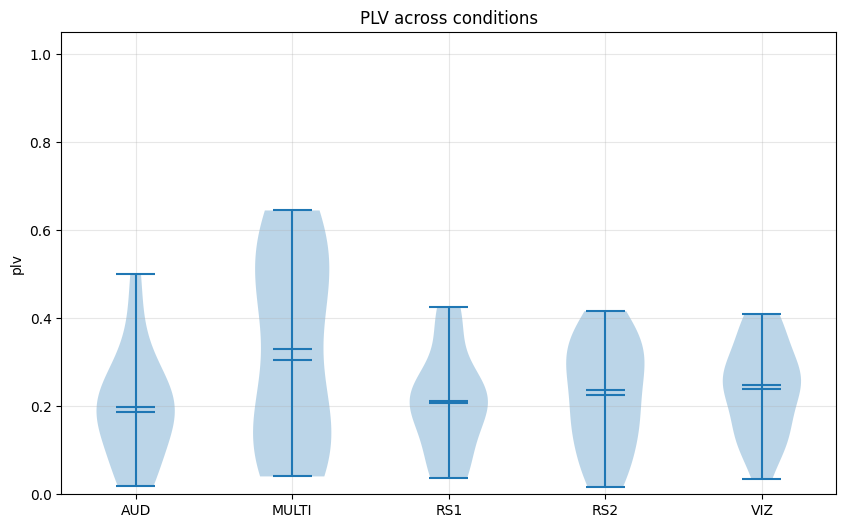

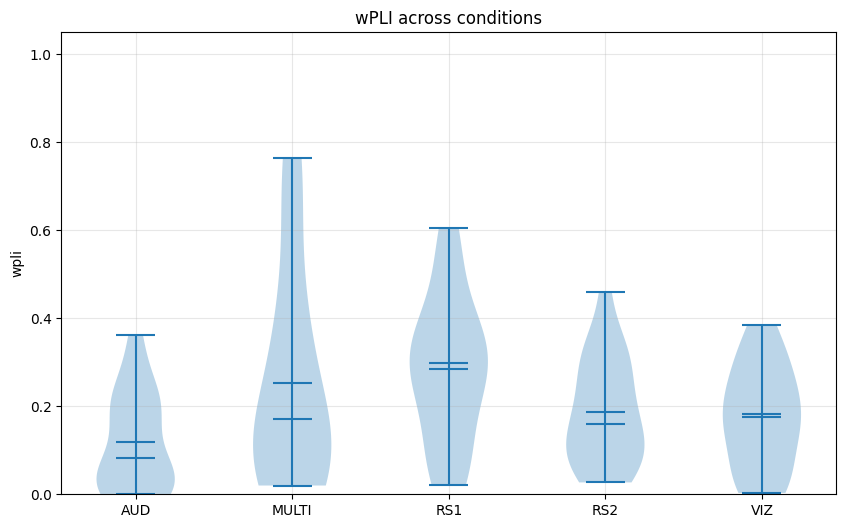

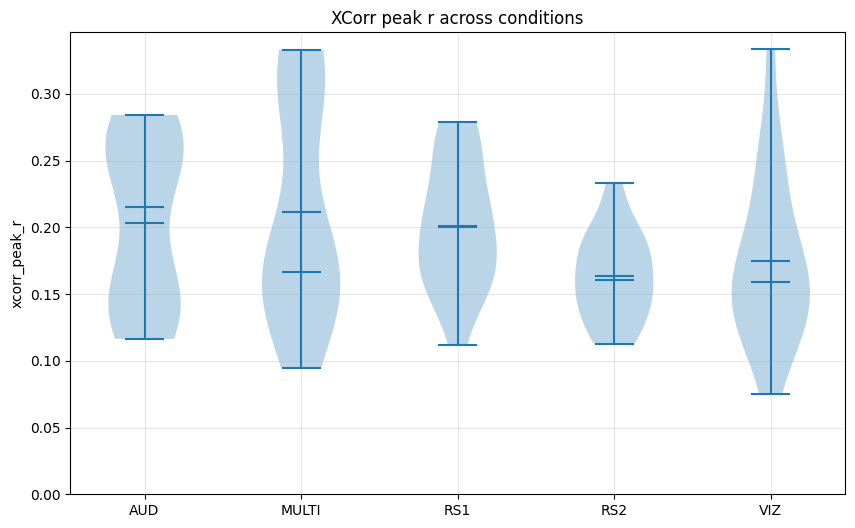

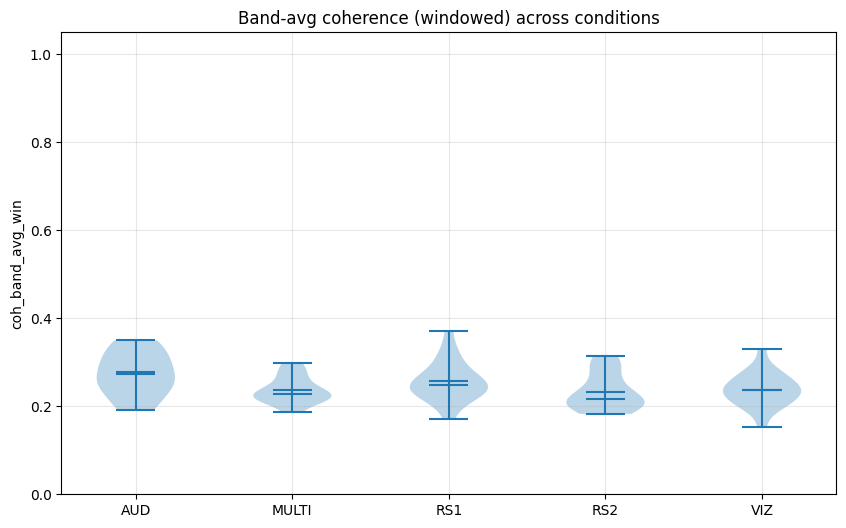

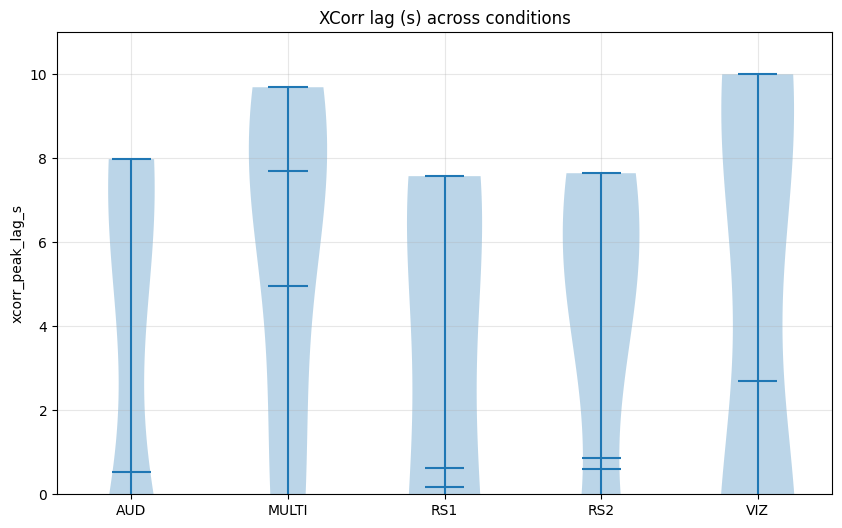

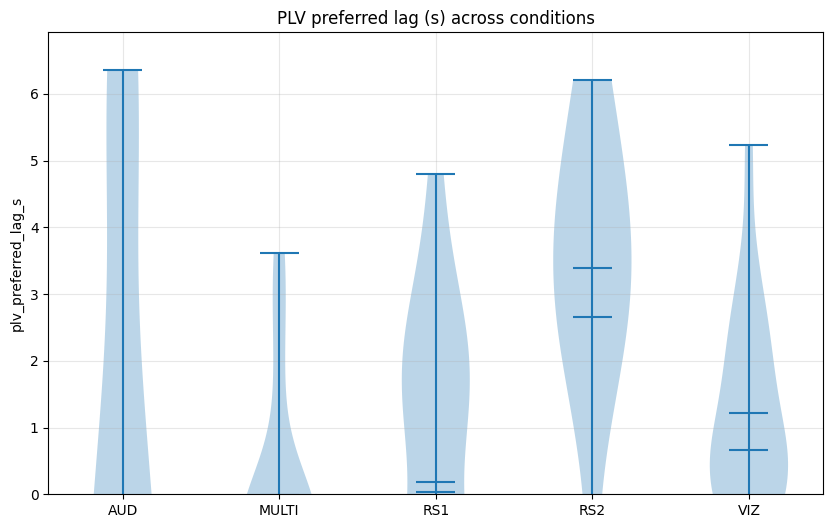

In [24]:
# Quick violins for this subject
win_df = pd.read_csv(tables / "coupling_windowed_values.csv")

def violin_by_condition(win_df, metric, title=None):
    subset = win_df[win_df["metric"] == metric]
    groups = [g["value"].dropna().to_numpy() for _, g in subset.groupby("condition")]
    labels = [k for k, _ in subset.groupby("condition")]
    import matplotlib.pyplot as plt, numpy as np
    if not groups:
        print("No data for", metric); return
    fig, ax = plt.subplots(figsize=(10,6))
    ax.violinplot(groups, showmeans=True, showmedians=True, showextrema=True)
    ax.set_xticks(np.arange(1, len(labels)+1)); ax.set_xticklabels(labels)
    ax.set_ylabel(metric); ax.set_title(title or f"{metric} across conditions")
    ax.set_ylim(0, 1.05 if metric in ("plv","wpli","coh_band_avg_win") else None)
    ax.grid(True, alpha=0.3); plt.show()

violin_by_condition(win_df, "plv",               "PLV across conditions")
violin_by_condition(win_df, "wpli",              "wPLI across conditions")
violin_by_condition(win_df, "xcorr_peak_r",      "XCorr peak r across conditions")
violin_by_condition(win_df, "coh_band_avg_win",  "Band-avg coherence (windowed) across conditions")
# lags (in seconds) if you want to compare timing:
violin_by_condition(win_df, "xcorr_peak_lag_s",  "XCorr lag (s) across conditions")
violin_by_condition(win_df, "plv_preferred_lag_s","PLV preferred lag (s) across conditions")


GROUP STATS

[02] wrote: C:\Users\andre\Documents\github\HumanNatureAttunement\data\processed\sub-02\tables\coupling_summary.csv  and  C:\Users\andre\Documents\github\HumanNatureAttunement\data\processed\sub-02\tables\coupling_windowed_values.csv
[03] wrote: C:\Users\andre\Documents\github\HumanNatureAttunement\data\processed\sub-03\tables\coupling_summary.csv  and  C:\Users\andre\Documents\github\HumanNatureAttunement\data\processed\sub-03\tables\coupling_windowed_values.csv
[05] wrote: C:\Users\andre\Documents\github\HumanNatureAttunement\data\processed\sub-05\tables\coupling_summary.csv  and  C:\Users\andre\Documents\github\HumanNatureAttunement\data\processed\sub-05\tables\coupling_windowed_values.csv
[06] wrote: C:\Users\andre\Documents\github\HumanNatureAttunement\data\processed\sub-06\tables\coupling_summary.csv  and  C:\Users\andre\Documents\github\HumanNatureAttunement\data\processed\sub-06\tables\coupling_windowed_values.csv
[07] wrote: C:\Users\andre\Documents\github\HumanNatureAttunemen

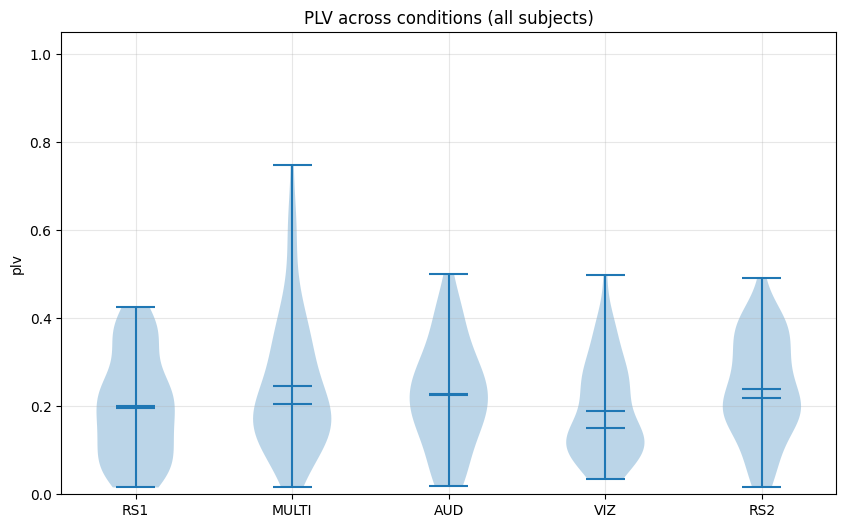

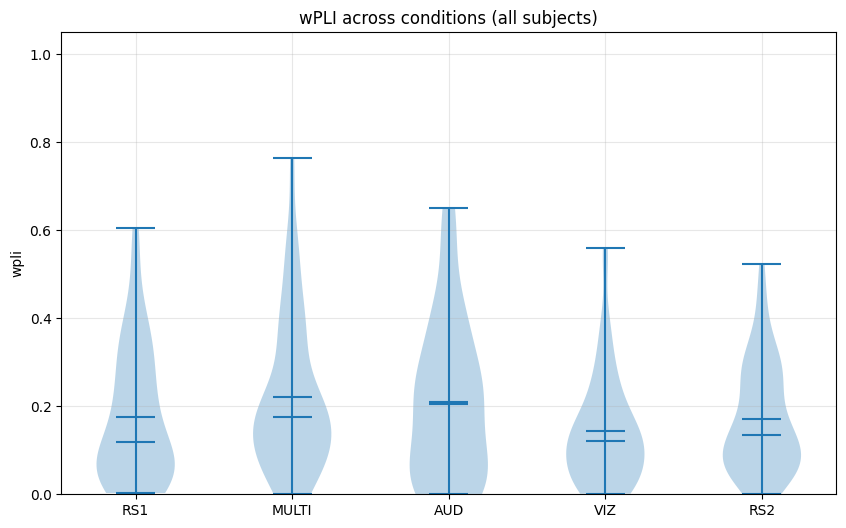

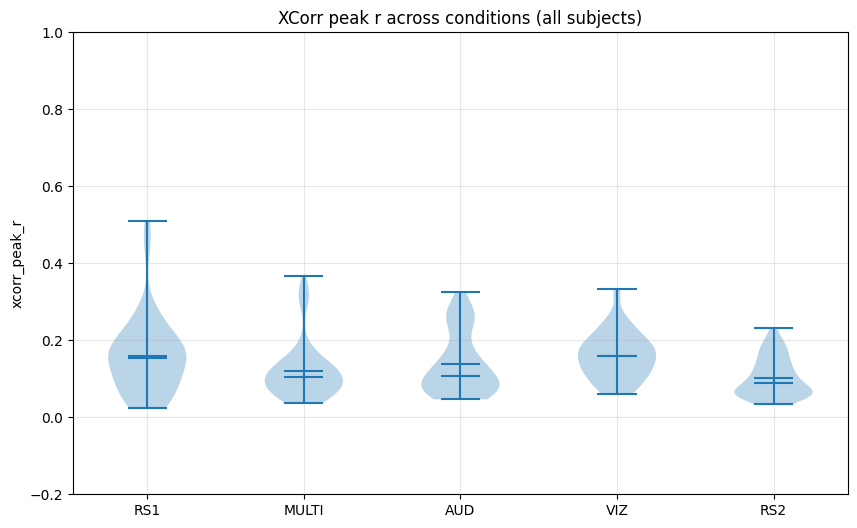

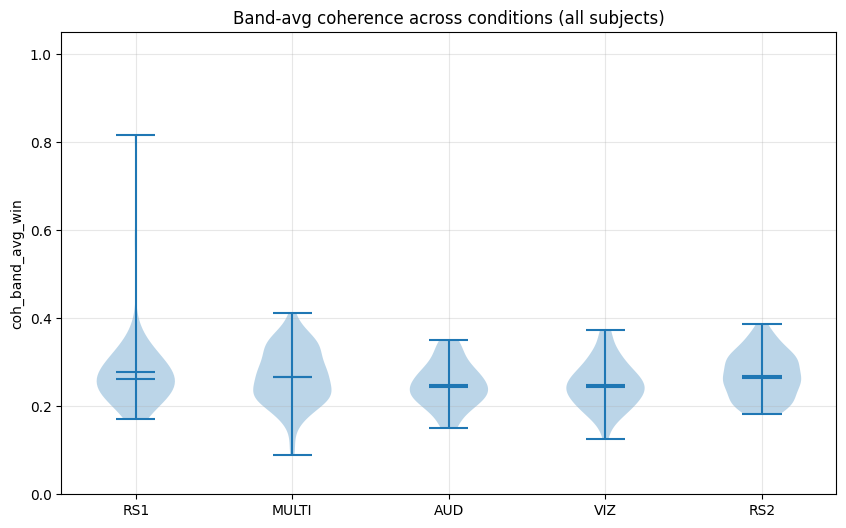

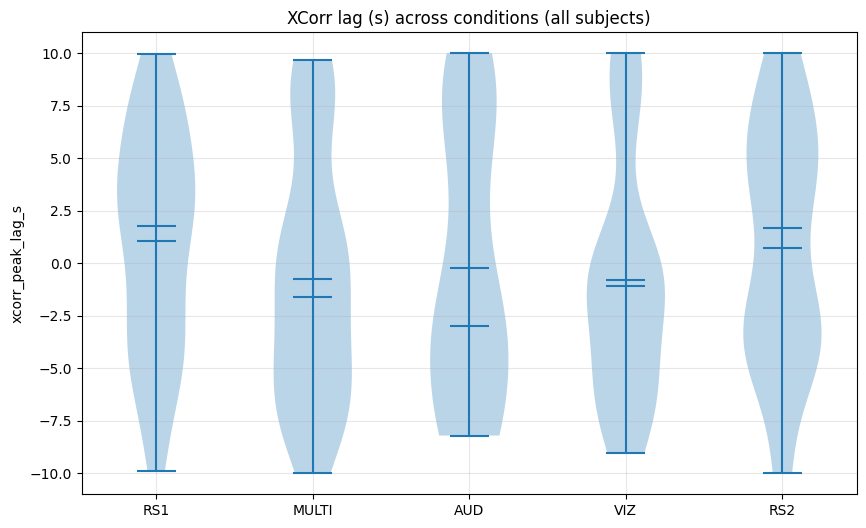

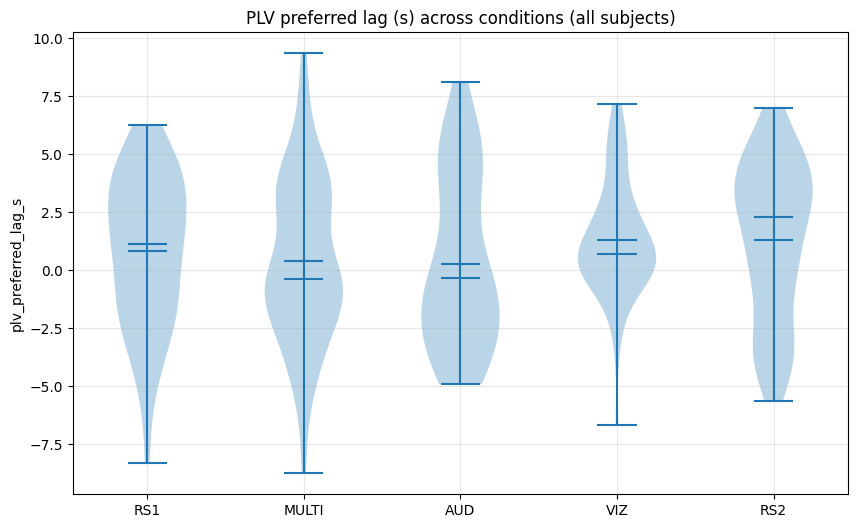

In [25]:
# Cell — Batch all subjects, pool to group CSVs, and draw violins

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

from HNA.modules.utils import get_condition_segments
from HNA.modules.coupling import (
    windowed_xcorr, band_coherence, band_coherence_windowed,
    plv_phase_sync, windowed_plv,
    wpli_phase_sync, windowed_wpli,
)

SUBJECTS = ["02", "03", "05", "06", "07"]  # change if needed

def process_subject_for_violins(subj: str):
    """Compute coupling for one subject, write per-subject CSVs, return (summary_df, windowed_df)."""
    tables = PROCESSED / f"sub-{int(subj):02d}" / "tables"
    tables.mkdir(parents=True, exist_ok=True)
    merged = tables / "merged_annotated_with_audio.csv"
    if not merged.exists():
        print(f"[{subj}] SKIP (missing table):", merged)
        return None, None

    df = pd.read_csv(merged, low_memory=False)
    if "time_s" not in df.columns:
        df["time_s"] = np.arange(len(df), dtype=float) / FS
    if "respiration_clean" not in df.columns:
        print(f"[{subj}] SKIP (missing respiration_clean). Run the respiration notebook first.")
        return None, None

    # choose which audio envelope to use
    env_col = choose_envelope_column(df)

    # segments by condition
    idx = get_condition_segments(df, df["condition_names"].unique())
    segments = pair_segments(idx)

    summary_rows, win_rows = [], []

    for cond, (start, stop) in segments.items():
        if str(cond).upper() == "AUDIO_SYNC":
            continue

        r = df.iloc[start:stop]
        resp = r["respiration_clean"].to_numpy(float)
        env  = r[env_col].to_numpy(float)
        seg_len_s = len(resp) / FS
        if len(resp) < 8 or len(env) < 8:
            # too short to be meaningful
            continue

        # --- global metrics
        plv_g  = plv_phase_sync(resp, env, fs=FS, bw_hz=PLV_BW)
        wpli_g = wpli_phase_sync(resp, env, fs=FS, bw_hz=PLV_BW)
        coh_g  = band_coherence(resp, env, fs=FS, fmin=COH_FMIN, fmax=COH_FMAX, windowed=False)

        # --- windowed (adaptive)
        params = effective_window_params(seg_len_s, FS, XC_WIN, XC_STEP, XC_LAG)
        if params is None:
            xc = None
            plv_w  = {"times_s": [], "plv": [], "preferred_lag_s": []}
            wpli_w = {"times_s": [], "wpli": []}
            coh_w  = {"times_s": [], "band_avg_coh_win": []}
        else:
            win_eff, step_eff, lag_eff = params
            xc     = windowed_xcorr(resp, env, fs=FS, win_sec=win_eff, step_sec=step_eff, max_lag_sec=lag_eff)
            plv_w  = windowed_plv(resp, env, fs=FS, win_sec=win_eff, step_sec=step_eff)
            wpli_w = windowed_wpli(resp, env, fs=FS, win_sec=win_eff, step_sec=step_eff)
            coh_w  = band_coherence_windowed(resp, env, fs=FS, fmin=COH_FMIN, fmax=COH_FMAX,
                                             win_sec=win_eff, step_sec=step_eff)

        # per-condition summary row (one row per condition)
        summary_rows.append({
            "subject": subj, "condition": cond, "env_col": env_col,
            "xcorr_mean_peak_r": (float(np.nanmean(xc.peak_r)) if xc is not None else np.nan),
            "xcorr_mean_peak_lag_s": (float(np.nanmean(xc.peak_lag_s)) if xc is not None else np.nan),
            "coh_band_avg": float(coh_g.band_avg_coh),
            "coh_peak": float(coh_g.peak_coh),
            "coh_peak_f": float(coh_g.peak_f),
            "plv": float(plv_g.plv),
            "plv_pref_lag_s": float(plv_g.preferred_lag_s),
            "plv_dom_f": float(plv_g.f0),
            "wpli": float(wpli_g.wpli),
        })

        # windowed rows (long-form for violins)
        # XCorr
        if xc is not None and len(xc.times_s) > 0:
            for t_i, r_i, lag_i in zip(xc.times_s, xc.peak_r, xc.peak_lag_s):
                if np.isfinite(r_i):
                    win_rows.append({"subject": subj, "condition": cond, "metric": "xcorr_peak_r",
                                     "time_s": float(t_i), "value": float(r_i)})
                if np.isfinite(lag_i):
                    win_rows.append({"subject": subj, "condition": cond, "metric": "xcorr_peak_lag_s",
                                     "time_s": float(t_i), "value": float(lag_i)})

        # PLV
        if len(plv_w["times_s"]) > 0:
            for t_i, v_i in zip(plv_w["times_s"], plv_w["plv"]):
                if np.isfinite(v_i):
                    win_rows.append({"subject": subj, "condition": cond, "metric": "plv",
                                     "time_s": float(t_i), "value": float(v_i)})
            for t_i, lag_i in zip(plv_w["times_s"], plv_w["preferred_lag_s"]):
                if np.isfinite(lag_i):
                    win_rows.append({"subject": subj, "condition": cond, "metric": "plv_preferred_lag_s",
                                     "time_s": float(t_i), "value": float(lag_i)})

        # wPLI
        if len(wpli_w["times_s"]) > 0:
            for t_i, v_i in zip(wpli_w["times_s"], wpli_w["wpli"]):
                if np.isfinite(v_i):
                    win_rows.append({"subject": subj, "condition": cond, "metric": "wpli",
                                     "time_s": float(t_i), "value": float(v_i)})

        # Coherence (band-average, windowed)
        coh_times = coh_w["times_s"] if isinstance(coh_w, dict) else getattr(coh_w, "times_s", [])
        coh_vals  = coh_w["band_avg_coh_win"] if isinstance(coh_w, dict) else getattr(coh_w, "band_avg_coh_win", [])
        if len(coh_times) > 0 and len(coh_vals) > 0:
            for t_i, v_i in zip(coh_times, coh_vals):
                if np.isfinite(v_i):
                    win_rows.append({"subject": subj, "condition": cond, "metric": "coh_band_avg_win",
                                     "time_s": float(t_i), "value": float(v_i)})

    # write per-subject CSVs
    summary_df  = pd.DataFrame(summary_rows).sort_values(["condition"])
    windowed_df = pd.DataFrame(win_rows)
    summary_df.to_csv(tables / "coupling_summary.csv", index=False)
    windowed_df.to_csv(tables / "coupling_windowed_values.csv", index=False)
    print(f"[{subj}] wrote: {tables / 'coupling_summary.csv'}  and  {tables / 'coupling_windowed_values.csv'}")
    return summary_df, windowed_df


# ---- Run all subjects and pool to group CSVs ----
group_summary = []
group_windowed = []

for s in SUBJECTS:
    ssum, swin = process_subject_for_violins(s)
    if ssum is not None:
        group_summary.append(ssum.assign(subject=s))
    if swin is not None and len(swin):
        group_windowed.append(swin.assign(subject=s))

group_summary_df  = pd.concat(group_summary,  ignore_index=True) if group_summary else pd.DataFrame()
group_windowed_df = pd.concat(group_windowed, ignore_index=True) if group_windowed else pd.DataFrame()

GROUP_DIR = PROCESSED / "group"
GROUP_DIR.mkdir(parents=True, exist_ok=True)

if not group_summary_df.empty:
    group_summary_df.to_csv(GROUP_DIR / "coupling_summary_all_subjects.csv", index=False)
if not group_windowed_df.empty:
    group_windowed_df.to_csv(GROUP_DIR / "coupling_windowed_values_all_subjects.csv", index=False)

print("\nGroup files:")
print(" ", GROUP_DIR / "coupling_summary_all_subjects.csv")
print(" ", GROUP_DIR / "coupling_windowed_values_all_subjects.csv")

# ---- Quick violin plots across conditions (pooled across subjects) ----

def violin_by_condition(df_long: pd.DataFrame, metric: str, title=None, ylim=None):
    sub = df_long[df_long["metric"] == metric].copy()
    if sub.empty:
        print("No data for", metric); return
    # order conditions by appearance
    cond_order = list(sub["condition"].dropna().unique())
    # gather data in order
    data = [sub.loc[sub["condition"]==c, "value"].dropna().to_numpy() for c in cond_order]

    fig, ax = plt.subplots(figsize=(10,6))
    ax.violinplot(data, showmeans=True, showmedians=True, showextrema=True)
    ax.set_xticks(np.arange(1, len(cond_order)+1))
    ax.set_xticklabels(cond_order, rotation=0)
    ax.set_ylabel(metric)
    ax.set_title(title or f"{metric} across conditions (all subjects)")
    if ylim is not None:
        ax.set_ylim(*ylim)
    elif metric in ("plv","wpli","coh_band_avg_win"):
        ax.set_ylim(0, 1.05)
    ax.grid(True, alpha=0.3)
    plt.show()

if not group_windowed_df.empty:
    violin_by_condition(group_windowed_df, "plv",              "PLV across conditions (all subjects)")
    violin_by_condition(group_windowed_df, "wpli",             "wPLI across conditions (all subjects)")
    violin_by_condition(group_windowed_df, "xcorr_peak_r",     "XCorr peak r across conditions (all subjects)", ylim=(-0.2, 1.0))
    violin_by_condition(group_windowed_df, "coh_band_avg_win", "Band-avg coherence across conditions (all subjects)")
    # lags
    violin_by_condition(group_windowed_df, "xcorr_peak_lag_s", "XCorr lag (s) across conditions (all subjects)")
    violin_by_condition(group_windowed_df, "plv_preferred_lag_s", "PLV preferred lag (s) across conditions (all subjects)")
else:
    print("No windowed data found to plot.")


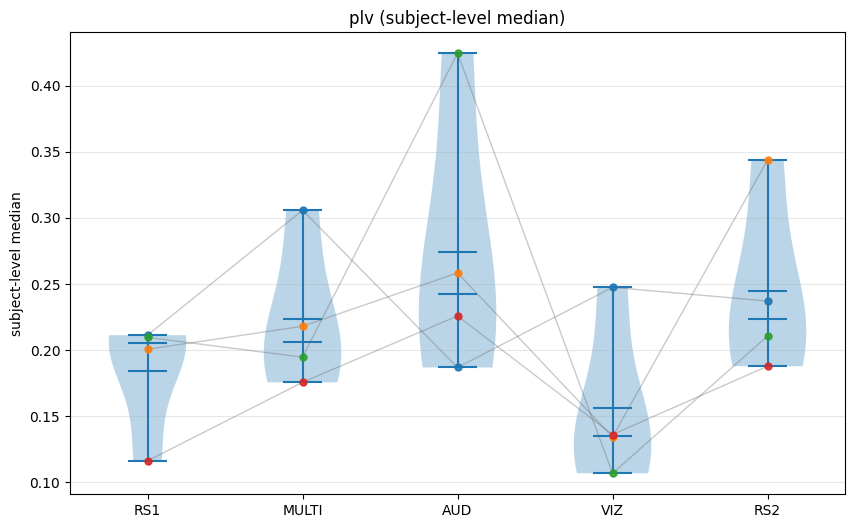

Friedman χ²=5.800, p=0.215  (subjects=4, conditions=5)

Holm-corrected Wilcoxon (two-sided):


,pair,raw_p,holm_p,signif_0.05
0,RS1 vs MULTI,0.250,1.0,False
1,RS1 vs AUD,0.250,1.0,False
2,RS1 vs VIZ,0.625,1.0,False
3,RS1 vs RS2,0.125,1.0,False
4,MULTI vs AUD,0.625,1.0,False
5,MULTI vs VIZ,0.125,1.0,False
6,MULTI vs RS2,0.625,1.0,False
7,AUD vs VIZ,0.250,1.0,False
8,AUD vs RS2,1.000,1.0,False
9,VIZ vs RS2,0.250,1.0,False


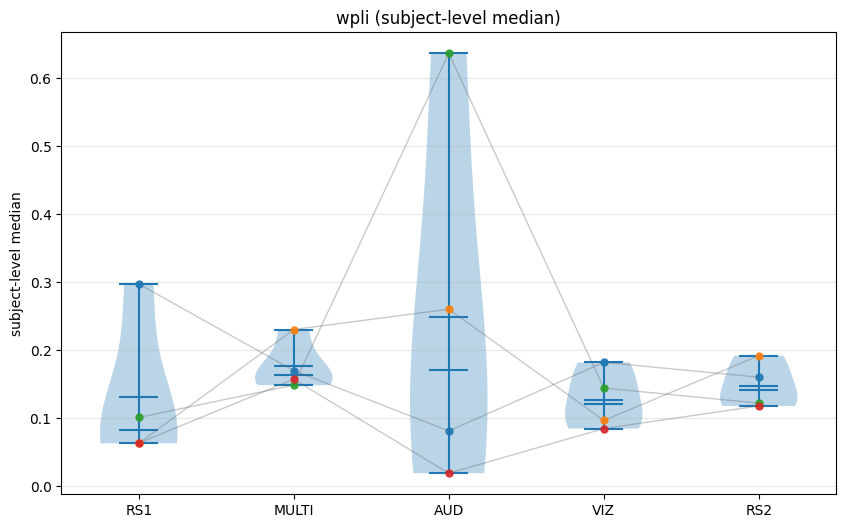

Friedman χ²=2.600, p=0.627  (subjects=4, conditions=5)

Holm-corrected Wilcoxon (two-sided):


,pair,raw_p,holm_p,signif_0.05
0,RS1 vs MULTI,0.625,1.0,False
1,RS1 vs AUD,0.875,1.0,False
2,RS1 vs VIZ,0.875,1.0,False
3,RS1 vs RS2,0.875,1.0,False
4,MULTI vs AUD,1.000,1.0,False
5,MULTI vs VIZ,0.375,1.0,False
6,MULTI vs RS2,0.125,1.0,False
7,AUD vs VIZ,0.625,1.0,False
8,AUD vs RS2,1.000,1.0,False
9,VIZ vs RS2,0.625,1.0,False


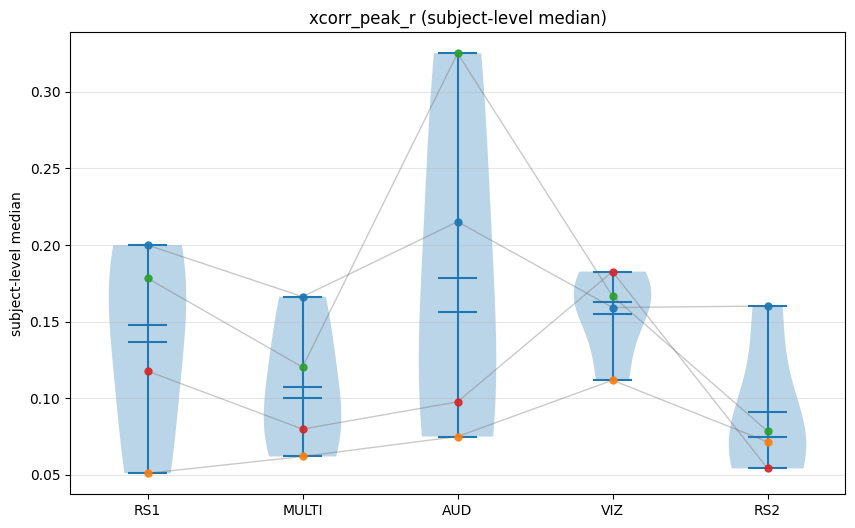

Friedman χ²=6.400, p=0.171  (subjects=4, conditions=5)

Holm-corrected Wilcoxon (two-sided):


,pair,raw_p,holm_p,signif_0.05
0,RS1 vs MULTI,0.250,1.0,False
1,RS1 vs AUD,0.375,1.0,False
2,RS1 vs VIZ,0.625,1.0,False
3,RS1 vs RS2,0.250,1.0,False
4,MULTI vs AUD,0.125,1.0,False
5,MULTI vs VIZ,0.250,1.0,False
6,MULTI vs RS2,0.375,1.0,False
7,AUD vs VIZ,0.875,1.0,False
8,AUD vs RS2,0.125,1.0,False
9,VIZ vs RS2,0.250,1.0,False


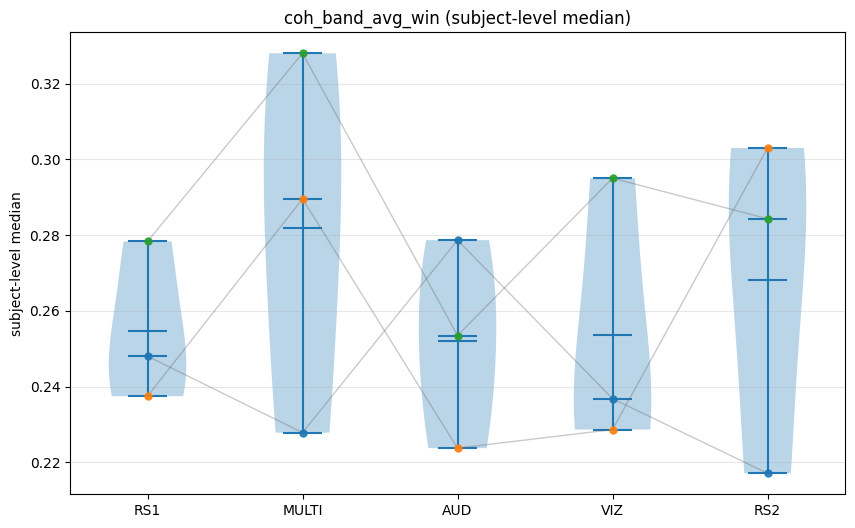

Friedman χ²=1.067, p=0.9  (subjects=3, conditions=5)

Holm-corrected Wilcoxon (two-sided):


,pair,raw_p,holm_p,signif_0.05
0,RS1 vs MULTI,0.50,1.0,False
1,RS1 vs AUD,1.00,1.0,False
2,RS1 vs VIZ,1.00,1.0,False
3,RS1 vs RS2,0.75,1.0,False
4,MULTI vs AUD,0.50,1.0,False
5,MULTI vs VIZ,0.50,1.0,False
6,MULTI vs RS2,0.75,1.0,False
7,AUD vs VIZ,1.00,1.0,False
8,AUD vs RS2,0.75,1.0,False
9,VIZ vs RS2,1.00,1.0,False


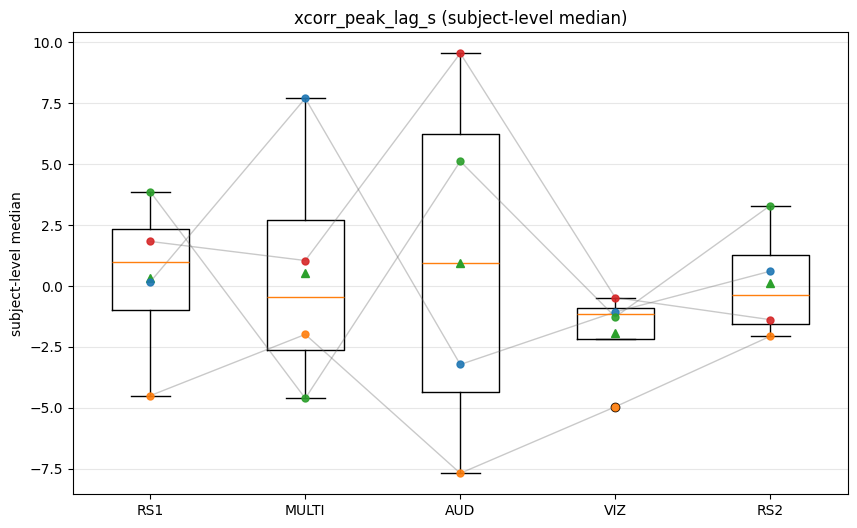

Friedman χ²=2.400, p=0.663  (subjects=4, conditions=5)

Holm-corrected Wilcoxon (two-sided):


,pair,raw_p,holm_p,signif_0.05
0,RS1 vs MULTI,1.000,1.0,False
1,RS1 vs AUD,1.000,1.0,False
2,RS1 vs VIZ,0.125,1.0,False
3,RS1 vs RS2,0.875,1.0,False
4,MULTI vs AUD,1.000,1.0,False
5,MULTI vs VIZ,0.625,1.0,False
6,MULTI vs RS2,0.875,1.0,False
7,AUD vs VIZ,0.625,1.0,False
8,AUD vs RS2,1.000,1.0,False
9,VIZ vs RS2,0.250,1.0,False


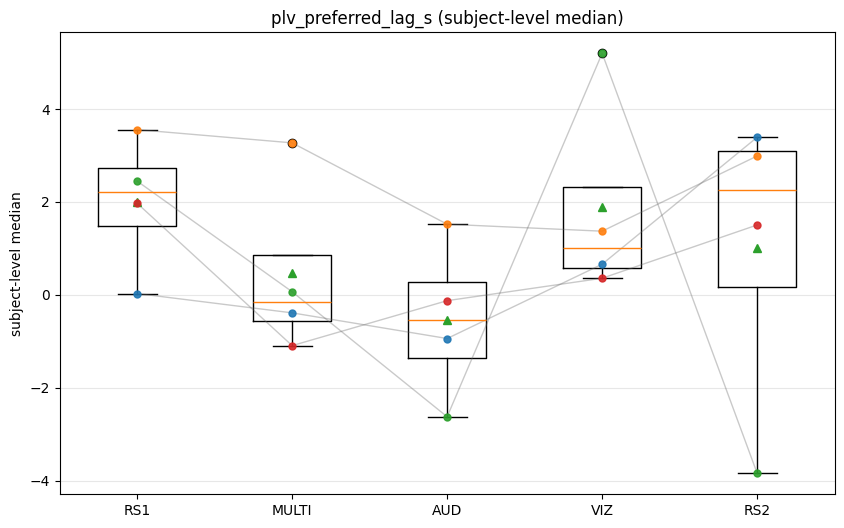

Friedman χ²=5.600, p=0.231  (subjects=4, conditions=5)

Holm-corrected Wilcoxon (two-sided):


,pair,raw_p,holm_p,signif_0.05
0,RS1 vs MULTI,0.125,1.0,False
1,RS1 vs AUD,0.125,1.0,False
2,RS1 vs VIZ,1.000,1.0,False
3,RS1 vs RS2,0.625,1.0,False
4,MULTI vs AUD,0.375,1.0,False
5,MULTI vs VIZ,0.625,1.0,False
6,MULTI vs RS2,1.000,1.0,False
7,AUD vs VIZ,0.250,1.0,False
8,AUD vs RS2,0.250,1.0,False
9,VIZ vs RS2,0.875,1.0,False


In [26]:
# Cell — Subject-level medians, violin/box with subject dots, Friedman + Holm-Wilcoxon

from pathlib import Path
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# ----- config -----
ROOT = Path(r"C:\Users\andre\Documents\github\HumanNatureAttunement")  # adjust if needed
GROUP_FILE = ROOT / "data" / "processed" / "group" / "coupling_windowed_values_all_subjects.csv"

# desired condition order (will fallback to whatever exists if some are missing)
DEFAULT_ORDER = ["RS1", "MULTI", "AUD", "VIZ", "RS2"]

# ===== helpers =====
def subject_level_table(df_long: pd.DataFrame, metric: str, agg: str = "median"):
    """Return wide table: rows=subjects, cols=conditions; values=subject-level agg of windowed 'value'."""
    sub = df_long[df_long["metric"] == metric].copy()
    if sub.empty:
        raise ValueError(f"No rows for metric='{metric}'.")
    g = sub.groupby(["subject", "condition"])["value"]
    series = g.median() if agg == "median" else g.mean()
    table = series.unstack("condition")
    # reorder columns by DEFAULT_ORDER if present
    cols = [c for c in DEFAULT_ORDER if c in table.columns] + [c for c in table.columns if c not in DEFAULT_ORDER]
    return table.loc[:, cols]

def friedman_and_posthoc_wilcoxon(tab: pd.DataFrame, alpha: float = 0.05):
    """Run Friedman (within-subjects) and pairwise Wilcoxon with Holm correction."""
    # keep only subjects with all selected conditions present
    clean = tab.dropna(axis=0, how="any")
    if clean.shape[0] < 3 or clean.shape[1] < 3:
        print("Not enough complete subjects/conditions for Friedman (need ≥3 subjects & ≥3 conditions).")
        return None, None

    # Friedman
    args = [clean[c].values for c in clean.columns]
    fr_stat, fr_p = stats.friedmanchisquare(*args)

    # pairwise Wilcoxon (two-sided) for all condition pairs
    pairs = list(itertools.combinations(clean.columns, 2))
    results = []
    for a, b in pairs:
        x, y = clean[a].values, clean[b].values
        diffs = x - y
        if np.allclose(diffs, 0):
            w_stat, p = np.nan, 1.0
        else:
            try:
                w_stat, p = stats.wilcoxon(x, y, zero_method="wilcox", alternative="two-sided", method="auto")
            except Exception:
                w_stat, p = np.nan, 1.0
        results.append({"pair": f"{a} vs {b}", "raw_p": float(p)})

    # Holm step-down correction
    m = len(results)
    order = np.argsort([r["raw_p"] for r in results])
    adj_p = [None]*m
    for rank, idx in enumerate(order):
        p = results[idx]["raw_p"]
        adj = p * (m - rank)
        # enforce monotonicity
        if rank == 0:
            adj_p[idx] = min(adj, 1.0)
        else:
            adj_p[idx] = min(max(adj_p[order[rank-1]], adj), 1.0)
    for i, r in enumerate(results):
        r["holm_p"] = float(adj_p[i])
        r["signif_0.05"] = r["holm_p"] < alpha

    posthoc_df = pd.DataFrame(results).sort_values("holm_p")
    return (fr_stat, fr_p), posthoc_df

def plot_subject_level(tab: pd.DataFrame, title: str = "", kind: str = "violin"):
    """Violin/box per condition with subject dots + paired lines."""
    clean = tab.dropna(axis=0, how="any")  # only subjects present in all conds
    conditions = list(clean.columns)
    xs = np.arange(1, len(conditions)+1)

    fig, ax = plt.subplots(figsize=(10,6))
    if kind == "violin":
        parts = ax.violinplot([clean[c].values for c in conditions],
                              positions=xs, showmeans=True, showmedians=True, showextrema=True)
    else:
        bp = ax.boxplot([clean[c].values for c in conditions],
                        positions=xs, showmeans=True, whis=1.5)

    # subject dots + paired lines
    for _, row in clean.iterrows():
        y = row.values.astype(float)
        ax.plot(xs, y, lw=1.0, alpha=0.35, color="0.4")
        ax.scatter(xs, y, s=25, alpha=0.9, zorder=3)

    ax.set_xticks(xs); ax.set_xticklabels(conditions)
    ax.set_xlim(0.5, len(conditions)+0.5)
    ax.set_ylabel("subject-level median")
    ax.set_title(title)
    ax.grid(True, axis="y", alpha=0.3)
    plt.show()
    return fig

# ===== run for a chosen metric =====
group_df = pd.read_csv(GROUP_FILE)

def analyze_metric(metric: str, agg: str = "median", kind: str = "violin"):
    tab = subject_level_table(group_df, metric=metric, agg=agg)
    # plot
    plot_subject_level(tab, title=f"{metric} (subject-level {agg})", kind=kind)
    # stats
    fried, post = friedman_and_posthoc_wilcoxon(tab)
    if fried is not None:
        fr_stat, fr_p = fried
        print(f"Friedman χ²={fr_stat:.3f}, p={fr_p:.3g}  (subjects={tab.dropna().shape[0]}, conditions={tab.shape[1]})")
        print("\nHolm-corrected Wilcoxon (two-sided):")
        display(post)
    else:
        print("Skipped stats due to insufficient complete data.")
    return tab

# ---- examples: run any/all of these
tab_plv  = analyze_metric("plv",              kind="violin")   # or kind="box"
tab_wpli = analyze_metric("wpli",             kind="violin")
tab_xc   = analyze_metric("xcorr_peak_r",     kind="violin")
tab_coh  = analyze_metric("coh_band_avg_win", kind="violin")
# lags (in seconds)
tab_xclag = analyze_metric("xcorr_peak_lag_s",     kind="box")
tab_plvlag= analyze_metric("plv_preferred_lag_s",  kind="box")
